# WhisperCat: a python webscraper designed to enable early detection of quiet signals of catastrophic illness.
James Schlitt 2015

In [1]:
from urllib import urlopen
from time import sleep, strftime
from copy import deepcopy
from dateutil import parser
from bs4 import BeautifulSoup
from random import random
from datetime import date, timedelta, datetime
import cPickle
import re

#import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sb
import collections as cl
import itertools as it

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, date2num, num2date
#matplotlib.style.use('ggplot')
%matplotlib inline  

delayGlobal = 0.3
fluUrl = 'https://flutrackers.com/forum/'

## Basic text operations

In [2]:
def hideJunk(row):
    """Deletes non-meaningful junk to assist in checking row length"""
    toDelete = ['\t','</div>','\r']
    for entry in toDelete:
        row = row.replace(entry,'')
    while '  ' in row:
        row = row.replace('  ',' ')
    return row


def clearJunk(row):
    """Removes text of no interest to user or parser"""
    toDelete = ['\t','\r','&amp']
    for entry in toDelete:
        row = row.replace(entry,'')
    while '  ' in row:
        row = row.replace('  ',' ')
    return row
    
    
def goodRow(row):
    """Returns true if contents of row appear to be useful"""
    toExclude = ['"stylesheet"','"text/javascript"']
    notExcluded = len([entry for entry in toExclude if entry in row]) == 0
    return len(hideJunk(row))>5 and notExcluded


def findLines(rows,text):
    """Finds linesnumber containing a given string"""
    text = text.lower()
    return [i for i in range(len(rows)) if text in rows[i].lower()]

## Basic Content Extractors


In [3]:
def subjectFromLine(rows,line):
    """Finds a link subject in a line of html"""
    try:
        return rows[line].split('>')[1].split('<')[0]
    except:
        return ''
    
    
def getLines(rows,marker):
    """Pulls all lines containing a given marker"""
    return [line for line in sorted(findLines(rows,marker))]


def getLinesContent(rows,marker):
    """Returns content from a row containing a given marker"""
    return [rows[line] for line in sorted(findLines(rows,marker))]

def linkFromLine(rows,line):
    """Finds a link in a line of html"""
    try:
        return [entry for entry in rows[line].split('"') if 'http' in entry][0]
    except:
        return 'null'
        
        
def getLinks(rows,lines,shift=1):
    """Pulls the links from a list of lines containing links"""
    return [linkFromLine(rows,line+shift) for line in lines]


def getTextLinks(rows):
    """Filters comment to list of embedded links from regular text"""
    lines = getLines(rows,'http')
    return getLinks(rows,lines,shift=0)


def getSubjects(rows,lines,shift=1):
    """Pulls the subjects from a list of lines containing links"""
    return [subjectFromLine(rows,line+shift) for line in lines]
    
    
def hasThing(rows,marker):
    """Returns true if a list of html rows contains at least one with the marker"""
    return len(getLines(rows,marker))!=0


def getLineLinkTopic(rows,marker,shift):
    """Pulls lines, links, and topics together"""
    lines = getLines(rows,marker)
    links = getLinks(rows,lines,shift=shift)
    topics = getSubjects(rows,lines,shift=shift)
    return lines,links,topics          

##Web Data Entry Points

In [4]:
def getSub(rows,startString='null',endString='null',pad=0):
    """Filters rows of text by start and end strings"""
    finalLine = len(rows)-1
    if startString != 'null':
        startLines = findLines(rows,startString)
        try:
            startLine = startLines[0]
        except:
            #print "\n\nCould not find startString %s in text, returning 0" % startString
            startLine = 0
    else:
        startLine = 0
    if endString != 'null':
        endLines = findLines(rows,endString)
        endLines = [row for row in endLines if row>=startLine]
        if endLines == []:
            endLine = finalLine
        else:
            endLine = endLines[0]
    else:
        endLine = finalLine
    return rows[max(startLine-pad,0):min(endLine+pad,finalLine)]


def getRows(url,startString='null',endString='null',pad=3,v=False):
    """Pulls rows of code from url between optional start and endstring containing rows"""
    text = '/'.join(url.split('/')[-2:])+','
    if v:
        print text,
        
    tries = 0; done = False
    html = ""
    while not done and tries < 20:
        try:
            #print "DEBOOF", url
            html = urlopen(url).read()
            done = True
        except:
            tries += 1
        if tries == 2:
            print "Can't pull, check your connection! Link:\t%s" % url
        sleep(delayGlobal+random())
    
    lines = html.split('\n')
    lines = [clearJunk(line) for line in lines if goodRow(line)]
    lines = getSub(lines,startString=startString,endString=endString,pad=pad)
    return lines

## Main Forum Tree Puller

In [5]:
def getMainData(rows):
    """Discerns forum top level structure"""
    marker='"forum-info"'
    lines = getLines(rows,marker)
    links = getLinks(rows,lines,shift=1)
    topics = getSubjects(rows,lines,shift=1)
    return {'lines':lines,
           'links':links,
           'topics':topics}


def getMainTree(url,recurs=0,topic='main',v=True):
    """Creates flattened subtopic tree by recursively scraping forum"""
    if v:
        print "Preparing tree pull for topic '%s', recursion level is %s" % (topic,recurs)
    recursive = recurs>0
    (start,end,billy) = {False:('welcome to flutrackers','francophones des flutrackers',3),
                         True:('null','null',0)}[recursive]
    if type(url) is not list:
        rows = getRows(url,
                   startString=start,
                   endString=end,
                   pad=billy)
    else:
        rows=url
    
    mainData = getMainData(rows)
    
    subLines,subLinks,subTopics = getLineLinkTopic(rows,'"subforum-info"',2)
    
    numTopics = len(mainData['lines'])
    numSubTopics = len(subTopics)
    
    lineIndex = mainData['lines']+[len(rows)+1]
    tree = dict()
    
    for i in range(numTopics):
        topic = mainData['topics'][i]
        line = mainData['lines'][i]
        line2 = lineIndex[i+1]
        link = mainData['links'][i]
        
        tree[topic] = {'subtopics':{},
                       'line':line,
                       'link':link,
                       'type':'topic'}
    
        subSubIndex = [j for j in range(numSubTopics) if subLines[j] >= line and subLines[j] <= line2]
        numSubSubs = len(subSubIndex)
        
        #isHighTopic = not hasThing(getRows(link),"topic-list-header") and recurs == 0
        #if isHighTopic or True:
        if True:
            subSubIndex += [-1]
        
        for index in subSubIndex:
                if index != -1:
                    subLink = subLinks[index]
                    currentSub = subTopics[index]
                    selfTopic = False
                else:
                    subLink = link
                    currentSub = 'self'
                    selfTopic = True
                subRows = getRows(subLink)
                hasSubForum = hasThing(subRows,'sub-forums')
                
                if selfTopic:
                    pageType = 'topic'
                elif hasSubForum:
                    pageType = 'subForum'
                else:
                    pageType = 'topic'
                    
                if hasSubForum and not selfTopic:
                    recurTree = getMainTree(subRows,recurs=recurs+1,topic=currentSub,v=v)
                    for recTopic in recurTree.keys():
                        newTopic = "%s [lvl%s] %s" % (currentSub,recurs+1,recTopic)
                        newLine = recurTree[recTopic]['line']
                        newLink = recurTree[recTopic]['link']
                        newType = recurTree[recTopic]['type']
                        tree[topic]['subtopics'][newTopic] = {'line':newLine,
                                                                  'link':newLink,
                                                                  'posts':{},
                                                                  'type':newType}
                tree[topic]['subtopics'][currentSub] = {'line':index,
                                                                  'link':subLink,
                                                                  'posts':{},
                                                                  'type':pageType}
                
    if recurs == 0:
        print "\nOPERATION COMPLETE!"
    return tree  


## Forum Specific Content Extractors


In [6]:
def getPageTotal(rows):
    """Finds number of pages for a thread or forum"""
    marker = '<span class="pagetotal">'
    lines = getLines(rows,marker)
    row = rows[lines[0]]
    return int(row.split(marker)[1].split('<')[0])
    
    
def matchOne(x,y,i,default='null'):
    """Finds first line in Y list of line refs after X[i]"""
    try:
        first = [entry for entry in y if entry >= x[i]][0]
        if i != len(x)-1:
            if x[i+1]<first:
                return "null"
        return first
    except:
        return "null"
    

def getDate(rows,line):
    """Extracts date from html row and converts to datetime object"""
    if line == 'null':
        return 'null'
    if 'datetime=' in rows[line]:
        return parser.parse(rows[line].split('datetime="')[1].split('"')[0])
    try:
        dtstr = rows[line].split('date">')[1].split('<')[0].lower()
        dtstr = dtstr.replace('today',strftime("%d/%m/%Y"))
        dtstr = dtstr.replace('yesterday',(date.today()-timedelta(1)).strftime("%d/%m/%Y"))
        return parser.parse(dtstr)
    except:
        print "Error: couldn't extract date from",rows[line]
        return 'null'


        
def getCount(rows,line):
    """Extracts integer count value"""
    try:
        return int(rows[line].split('count">')[1].split(' ')[0].replace(',',''))
    except:
        return 'null'

    
def getText(rows,line):
    """Pulls comment html"""
    endString = '<!-- REPLY -->'
    kept = []; i = line+1; text = rows[i]
    while endString not in text:
        kept.append(text)
        i += 1
        text = rows[i]
    return kept


def cleanText(rows):
    """Filters comment html to regular text"""
    text = '\n'.join(BeautifulSoup('\n'.join(rows)).findAll(text=True))
    while '\n\n' in text:
        text = text.replace('\n\n','\n')
    text = re.sub('<[^<]+?>', '', text)
    #text.replace('\x85','')
    return text

## Forum Text Scraper: rescursively pulls texts and meta data from comments

In [7]:
def prepPosts(rows,pageType='posts'):
    """Extracts organized metadata for storage and analysis"""
    if pageType == 'posts':
        blockLines = getLines(rows,'<!-- BEGIN: display_Topics_item -->')
        
        lineRefs = {'sticky':getLines(rows,'<span class="prefix">Sticky: </span>'),
             'link':getLines(rows,'<a href="https:'),
             'creator':getLines(rows,'Started by <a href='),
             'updated':[i+2 for i in getLines(rows,'<div class="lastpost-by">')]+getLines(rows,'<time itemprop="dateCreated"'),
             'counts':getLines(rows,'<td class="cell-count">')}
        
        prepped = dict()
        
        extractors = {'sticky':lambda rows,refs: refs['sticky'] != 'null',
             'subject':lambda rows,refs: subjectFromLine(rows,refs['link']),
             'link':lambda rows,refs: linkFromLine(rows,refs['link']),
             'comments':lambda rows,refs: prepPosts(getRows(linkFromLine(rows,refs['link']),v=False),pageType='comments'),
             'creator':lambda rows,refs: linkFromLine(rows,refs['creator']),
             'created':lambda rows,refs: getDate(rows,refs['creator']),
             'updated':lambda rows,refs: getDate(rows,refs['updated']),
             'views':lambda rows,refs: getCount(rows,refs['counts']+2),
             'votes':lambda rows,refs: getCount(rows,refs['counts']+3),
             'posts':lambda rows,refs: getCount(rows,refs['counts']+1)}
        
    elif pageType == 'comments':
        blockLines = getLines(rows,'<div class="userinfo b-userinfo b-post__hide-when-deleted"')
        
        lineRefs = {'author':getLines(rows,'<div class="author h-text-size--14"'),
                    'created':getLines(rows,'<time itemprop="dateCreated"'),
                    'contentStart':getLines(rows,'<div class="js-post__content-text')}
        
        prepped = []
        
        extractors = {'author': lambda rows,refs: linkFromLine(rows,refs['author']),
                     'created': lambda rows,refs: getDate(rows,refs['created']),
                     'text': lambda rows,refs: cleanText(getText(rows,refs['contentStart'])),
                     'links': lambda rows,refs: getTextLinks(getText(rows,refs['contentStart']))}
        #'source:': lambda rows,refs: getText(rows,refs['contentStart']),
    
    matched = []
    for i in range(len(blockLines)):
        matches = dict((key,matchOne(blockLines,item,i)) for key,item in lineRefs.iteritems()) 
        matched.append(deepcopy(matches))
        

    if pageType == 'posts':
        for match in matched:
            try:
                extracted = dict((key,fx(rows,match)) for key,fx in extractors.iteritems())
            except:
                print "DEBOO PAGETYPE == POSTS"
                extracted = dict((key,fx(rows,match)) for key,fx in extractors.iteritems())
            prepped[extracted['subject']] = deepcopy(extracted)
            
    elif pageType == 'comments':
        for match in matched:
            extracted = dict((key,fx(rows,match)) for key,fx in extractors.iteritems())
            prepped.append(deepcopy(extracted))
    
    return prepped

In [8]:
def tryLinks(link,pageType='posts'):
    """Follows forum tree links to pull and map posts"""
    if pageType == 'posts':
        pageParams = '?filter_order=asc&filter_sort=created'
        start = '<!-- BEGIN: display_Topics -->'
        end = '<!-- BEGIN: profile_media -->'
        #end = '<div class="pagenav-container noselect">'
    elif pageType == 'comments':
        pageParams = ''
        start = '<!-- BEGIN: conversation_userinfo -->'
        end = '<div class="pagenav-container noselect'
        #end = '<!-- END: widget_conversationdisplay -->'
        
    results = [link+pageParams]
    contents = [getRows(link,v=False)]
    pages = getPageTotal(contents[0])
    page = 2

    while page <= pages:
        print page,pages
        toTry = ("%s/page%s%s" % (link,page,pageParams)).replace('//page','/page')
        requested = getRows(toTry,v=False)
        results.append(toTry)
        contents.append(requested)
        page += 1
    
    contents = [getSub(rows,startString=start,endString=end) for rows in contents]
    contents = '\n'.join(['\n'.join(i) for i in contents]).split('\n')
    contents = prepPosts(rows,pageType=pageType)
    return {'results':results,
           'contents':contents}

## Post data extractor 


In [9]:
def pullAll(fluUrl,v=True):
    """Master command, will pull the full tree"""
    if type(fluUrl) is not dict:
        tree = getMainTree(fluUrl,v=v)
    else:
        tree = deepcopy(fluUrl)
    for uppertopic in tree.keys():
        for subtopic in tree[uppertopic]['subtopics'].keys():
            if tree[uppertopic]['subtopics'][subtopic]['type'] == 'topic':
                pulled = tryLinks(tree[uppertopic]['subtopics'][subtopic]['link'])
                tree[uppertopic]['subtopics'][subtopic]['posts'] = deepcopy(pulled)
    print "\n\nFULL DATA PULL COMPLETED!"
    return tree

#Analysis Functions

###Tree operations

In [10]:
def hasOne(terms,body):
    """Returns true if any of a list of words are found within a string"""
    if type(body) is not str and type(body) is not unicode:
        return False
    body = body.lower()
    return len([term for term in terms if term.lower() in body]) != 0


def mapTree(tree,tabs=''):
    """Provides a brief map of the data contained within a tree"""
    if type(tree) is dict:
        iterator = tree.keys()
    elif type(tree) is list:
        iterator = range(len(tree))
    
    noShow = ['votes','views','posts','created','updated','sticky',
             'line','link','type','creator','author','text','links']
    
    for i in iterator:
        if i not in noShow:
            textI = str(i)
            print tabs+(textI[:40] + '..') if len(textI) > 40 else textI
            checked = tree[i]
            if type(tree[i]) in [list,dict]:
                mapTree(checked,tabs=tabs+'\t')

            
def recSearchTree(tree,terms,refs='',direct=True):
    """Recursively searches a tree for a given list of terms,
    returns list of tree pointers"""
    found = []
    if type(terms) is not list:
        terms = [terms]
    
    if type(tree) is dict:
        iterator = tree.keys()
    elif type(tree) is list:
        iterator = range(len(tree))
        
    for i in iterator:
        checked = tree[i]; wrap = '"'*(type(i) is str)
        if type(checked) in [list,dict]:
            found += recSearchTree(checked,terms,refs='%s[%s%s%s]' % (refs,wrap,i,wrap))
        if (hasOne(terms,checked) or hasOne(terms,i)) == direct:
            if i == 'text':
                found += [refs]
            else:
                found += ['%s[%s%s%s]' % (refs,wrap,i,wrap)]            
    return sorted(found)


def prepOne(sparseTree,path):
    """Creates missing structures in tree for reference path"""
    flattened = flatKeys = path.split('][')
    flattened[0] = flattened[0][1:]
    flattened[-1] = flattened[-1][:-1]
    for i in range(2,len(flattened)+1):
        try:
            cmd = 'temp = sparseTree[%s]' % ']['.join(flattened[0:i])
            exec(cmd)
        except Exception,e: 
            try:
                cmd3 = 'temp = type(sparseTree[%s])' % ']['.join(flattened[0:i-1])
                exec(cmd3)
            except:
                cmd2 = 'sparseTree[%s] = dict()' % ']['.join(flattened[0:i-1])
                exec(cmd2)
    return sparseTree


def getSubTree(tree,searchTerms='null',v=True,direct=True):
    """Returns a smaller tree of entries including the investigators search terms"""
    newTree = dict()
    if type(searchTerms) is str:
        searchTerms = [searchTerms]
    if searchTerms != 'null':
        searchResults = recSearchTree(tree,searchTerms,direct=direct)
        print "%s results found for queries %s\n" % (len(searchResults),searchTerms)
        for path in searchResults:
            newTree = prepOne(newTree,path)
            exec("newTree%s = deepcopy(tree%s)" % (path,path))
            
    if v:
        mapTree(newTree)
    
    return newTree

##Time operations

In [11]:
def getTimes(tree,upKey='null'):
    """For a given tree or sub tree, returns a list of times categorized by
    topic, thread, and reply creation"""
    topicStarts = []
    threadStarts = []
    threadReplies = []
    
    if type(tree) is dict:
        iterator = tree.keys()
    elif type(tree) is list:
        iterator = range(len(tree))
        
    for i in iterator:
        checked = tree[i]
        if type(checked) in [list,dict]:
            returned = getTimes(checked,upKey=i)
            topicStarts += returned['topics']
            threadStarts += returned['threads']
            threadReplies += returned['replies']
            
        elif 'date' in str(type(checked)) or 'time' in str(type(checked)):
            if "creator" in iterator:
                topicStarts.append(checked)
            else:
                if upKey == 0:
                    threadStarts.append(checked)
                else:
                    threadReplies.append(checked)
    if upKey == 'null':
        print "%s topics, %s new threads, and %s replies found" % (len(topicStarts),
                                                                  len(threadStarts),
                                                                  len(threadReplies))
    return {'topics':topicStarts,
            'threads':threadStarts,
            'replies':threadReplies}


def trimRange(collected,start,end):
    """Trim date range by plain text times"""
    if type(start) is str:
        start = parser.parse(start)
    if type(end) is str:
        end = parser.parse(end)
    if start > end:
        start,end = end,start
    holder = deepcopy(collected)
    for key in collected.keys():
        collected[key] = [entry for entry in collected[key] if entry > start and entry < end]
    return collected

##Visualizations

In [12]:
def timePlot(times,bigTitle,timeShift=0,divFactor=24,overlay = True, show = True):
    """ draw the histogram of activity by date distribution """
    ax = plt.figure(figsize=(11,5)).gca()
    merged = []
    prepped = [] 
    
    if type(times) is dict:
        dataIn = times.values()
        titles = times.keys()
        
    else:
        dataIn = times
        titles = 'Posts'
    
    for ytime in dataIn:
        numtime = [date2num(t) for t in list(ytime)] 
        merged += numtime
        prepped.append(numtime)
        
    first = num2date(min(merged))
    last = num2date(max(merged))
    
    hour = timedelta(hours=1) 
    minute = timedelta(minutes=1)
    
    firstRounded = first.replace(second=0,minute=0)
    lastRounded = last.replace(second=0,minute=0) + hour
    plotMin = date2num(firstRounded)
    plotMax = date2num(lastRounded)
    dateFirst = first.strftime("%a %m/%d/%y")
    dateLast = last.strftime("%a %m/%d/%y")
    timeSuffix = " from %s to %s" % (dateFirst,dateLast)
    
    difference = (lastRounded-firstRounded)
    hourBlocks = difference.days*24 + difference.seconds//3600
    if hourBlocks%2 != 0:
        plotMax = date2num(lastRounded + hour)
        hourBlocks += 1

    while (hourBlocks/divFactor) <= 1 and divFactor > 1:
        divFactor = divFactor/4
    
    plotTitle = titles[0]
    for i in range(len(prepped)):
        if overlay:
            numtime = prepped[i]
            _, _, patches = plt.hist(numtime, bins=(hourBlocks)/divFactor, alpha=0.5, 
                                    stacked=False, range=(plotMin,plotMax))
    if not overlay:
        _, _, patches = plt.hist(prepped, bins=(hourBlocks)/divFactor, alpha=0.5, 
                                    stacked=True, range=(plotMin,plotMax))
    
    plt.xlabel("Date/time (GMT %s)" % timeShift)
    plt.gca().set_xlim([plotMin,plotMax])
    plt.ylabel("Activity")
    plt.legend(titles,"best")
    plt.title(bigTitle+timeSuffix,size=16)
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d/%y'))
    
    plt.show()
    return plt


def plotLastYear(tree,terms,title):
    """Quickly plot a year of data for a given terms list"""
    hoursInWeek = 168
    sub = getSubTree(tree,searchTerms=terms,v=False)
    times = getTimes(sub)
    rightNow = datetime.now()
    lastYear = datetime.now() - timedelta(days=365)
    recent = trimRange(times,rightNow,lastYear)
    timePlot(recent,title,divFactor=hoursInWeek,overlay=False)

In [13]:
def isInt(text):
    """Returns true if number is an integer"""
    try:
        int(text.strip())
        return True
    except:
        return False

def findSplit(row,listed,orient):
    """Returns portion of row aside a marker"""
    if type(listed) is str:
        listed = [listed]
    keepKey = {'left':0,'right':1}[orient]
    for entry in listed:
        splitRow = row.lower().split(entry.lower())
        if len(splitRow) != 1:
            return splitRow[keepKey]
    return row
        
def getBetween(row,start='null',end='null'):
    """Returns portion of row between two markers"""
    success = True
    if start != 'null':
        row = findSplit(row,start,'right')
    if end != 'null':
        row = findSplit(row,end,'left')
    return row

##Line listing parsers

In [14]:
def getCaseAge(row):
    """Finds age of case"""
    caseAge = int(row.lower().split('man,')[1].split(',')[0].strip())
    return caseAge
    
def getCaseGender(row):
    """Finds gender of case"""
    return {True:'female',False:'male'}['woman' in row.split('</a>')[1][0:15].lower()]
    
def getCaseIndex(row):
    """Finds index of case"""
    return int(row.split('>#')[1].split('<')[0])

def getCaseDeath(row):
    """Determines death of case"""
    return '<b><font color="Red">Death</font></b>' in row


def getCaseSymptomTime(row):
    """Gets date of symptomatic phase"""
    symptomStrings = ['onset date',
                      'became ill on',
                      'of symptoms']
    dateChunk = getBetween(row,start=symptomStrings,end=']')
    return parser.parse(dateChunk.replace('[',''))
    
def getCaseHospitalTime(row):
    """Gets date of hospitalization"""
    hospitalStrings = ['hospitalized on'
                     'hospitalized']
    dateChunk = getBetween(row,start=hospitalStrings,end=']')
    return parser.parse(dateChunk.replace('[',''))
                      
def getCaseDeathTime(row):
    """Gets date of death"""
    deathStrings = ['deceased',
                   'passed away',
                   'died']
    dateChunk = getBetween(row,start=deathStrings,end=']')
    return parser.parse(dateChunk.replace('[',''))

def pickOne(row,options):
    """Returns first entry it finds in options"""
    row = row.lower().replace(',',' ').replace('<',' ')
    for category in options:
        for item in category:
            if (' %s ' % item.lower()) in row:
                return category[0]
    return np.nan

def pickAll(row,options):
    """Returns all entries it finds from options"""
    found = []
    row = row.lower().replace(',',' ').replace('<',' ')
    for item in options:
        if type(item) is str:
            item = [item]
        for i in item:
            if (' %s ' % i.lower()) in row:
                found.append(item[0])
    if found == []:
        return 'none'
    return ', '.join(sorted(found))


def hasAny(row,options):
    """Returns true if any options are found"""
    return pickOne(row,options) != np.nan

##DataFrame constructor

In [15]:
def caseLinesToDf(rows,categories={},lists={}):
    """Creates df from line listing"""
    df = pd.DataFrame()
    
    def tryIt(fx,rows):
        derived = []
        for row in rows:
            try:
                derived.append(fx(row))
            except:
                derived.append(np.nan)
        return derived
    
    for cat,options in categories.iteritems():
        df[cat] = [pickOne(row,options) for row in rows]
    df['gender'] = tryIt(getCaseGender,rows)
    df['age'] = tryIt(getCaseAge,rows)
    df['died'] = tryIt(getCaseDeath,rows)
    df['tSymptomatic'] = tryIt(getCaseSymptomTime,rows)
    df['tHospital'] = tryIt(getCaseHospitalTime,rows)
    df['tDeath'] = tryIt(getCaseDeathTime,rows)
    for cat,options in lists.iteritems():
        df[cat] = [pickAll(row,options) for row in rows]
    df['caseIndex'] = tryIt(getCaseIndex,rows)
    df['links'] = getTextLinks(rows)
    #df['report'] = [cleanText([row]) for row in rows]
    return df

#Demo Plot Source

In [35]:
def makeHists(stats,labels,title,i=10):
    """Creates overlapping histograms"""
    fig = plt.figure(figsize=(9,5))
    plt.hist(stats, i)
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title(title)
    plt.legend(labels)
    plt.show()
    
def joinCompound(stats,sep=', ',cleanUp=True):
    """Separates compound data fields"""
    if cleanUp:
        stats = [entry for entry in stats if entry != np.nan]
    if type(stats[0]) is str:
        stats = [item.split(', ') for item in stats]
    if cleanUp:
        stats = list(it.chain(*stats))
    return stats
    

def plotCol(stats,title,threshold=5,hide={'none',np.nan},compound=False):
    """Plots bar graphs by a column"""
    plt.figure(figsize=(9,5))
    if compound:
        stats = joinCompound(stats)
    count = dict(cl.Counter(stats))
    newDict = {'other':0}
    for key,value in count.iteritems():
        if key in hide:
            None
        elif value<=threshold:
            newDict['other']+=value
        else:
            newDict[key] = value
    if newDict['other'] == 0:
        del newDict['other']
    index = range(0,len(newDict.keys()))
    outKeys = sorted(newDict, key=newDict.get, reverse=True)
    outVals = sorted(newDict.values(),reverse=True)
    
    plt.bar(index,outVals)
    plt.xticks(index,outKeys,rotation='vertical')
    plt.ylabel('number')
    completed = float(sum(newDict.values()))/sum(count.values())
    plt.title("%s from %s%% of Entries Completed" % (title,int(100*completed)))
    plt.show()
    
def getSorter(stats,compound=False,threshold=5,hide={'none',np.nan}):
    """Creates sorting dictionary for abbreviating dataframes"""
    sorter = {'none':'none'}; counts = {'other':0}
    if type(stats[0]) is list:
        stats = list(it.chain(*stats))
    count = dict(cl.Counter(stats))
    for key,value in count.iteritems():
        if key in hide:
            None
        elif value<=threshold:
            sorter[key] = 'other'
            counts['other'] += value
        else:
            sorter[key] = key
            counts[key] = value
    outKeys = sorted(counts, key=counts.get, reverse=True)
    outVals = sorted(counts.values(),reverse=True)

    return sorter,outKeys,outVals

def getKey(sorter,attempt):
    """Returns none str if key not found"""
    try:
        return sorter[attempt]
    except:
        return 'none'

def fillCatDf(dataDf,sorterX,sorterY,indexX,indexY,featX,featY):
    """Parses line listing into count of hits by two columns"""
    catDf = pd.DataFrame(0,index=indexX+['none'],columns=indexY+['none'])
    for line,row in dataDf.iterrows():
        xItem = row[featX]
        yItem = row[featY]
        if type(xItem) is not list:
            xItem = [xItem]
        if type(yItem) is not list:
            yItem = [yItem]
        for i in xItem:
            for j in yItem:
                keyI = getKey(sorterX,i)
                keyJ = getKey(sorterY,j)
                catDf[keyJ][keyI] +=1.
    return catDf
            
def weightDfBySum(data):
    """Creates new df weighting columns by percentage of sum of entry"""
    colsOut = list(data.columns)[:-1] 
    indexOut = list(data.index)[:-1]
    newDf = pd.DataFrame(0.0,columns=colsOut,index=indexOut)
    for i in colsOut:
        colSum = sum(list(data[i]))
        if colSum !=0:
            for j in indexOut:
                newDf[i][j] = float(data[i][j])/colSum
    return newDf

def plotMortalityByFeatures(dataIn,featX,featY,compound=False,
                            death='died',threshold=5,hide={'none',np.nan}):
    """Plots mortality by x column and y column features"""
                                  
    dataDf = deepcopy(dataIn)
    dataDf = dataDf[pd.notnull(dataDf[death])]
    deathsDf = dataDf[dataDf[death] == True]
                                  
    if compound:
        dataDf[featX] = joinCompound(dataDf[featX],cleanUp=False)
        dataDf[featY] = joinCompound(dataDf[featY],cleanUp=False)
                                  
    sorterX,indexX,temp = getSorter(list(dataDf[featX]),threshold=threshold,hide=hide)
    sorterY,indexY,temp = getSorter(list(dataDf[featY]),threshold=threshold,hide=hide)
    
    allMapDf = fillCatDf(dataDf,sorterX,sorterY,indexX,indexY,featX,featY)
    diedMapDf = fillCatDf(deathsDf,sorterX,sorterY,indexX,indexY,featX,featY)
    weightedDf = weightDfBySum(allMapDf)
    
    plt.figure(figsize=(8,6))
    plt.pcolor(weightedDf,cmap='YlOrRd')
    plt.yticks(np.arange(0.5, len(weightedDf.index), 1), weightedDf.index)
    plt.xticks(np.arange(0.5, len(weightedDf.columns), 1), weightedDf.columns,rotation='vertical')
    plt.title("Frequency of %s by %s" % (featX,featY))
    cbar = plt.colorbar()
    plt.show()
    plt.close()
    
    survivalDf = diedMapDf/allMapDf
    survTemp = survivalDf.fillna(1.15)
  
    
    plt.figure(figsize=(8,6))
    plt.pcolor(survTemp,cmap='YlOrRd')
    plt.yticks(np.arange(0.5, len(survivalDf.index), 1), survivalDf.index)
    plt.xticks(np.arange(0.5, len(survivalDf.columns), 1), survivalDf.columns,rotation='vertical')
    plt.title("Mortality by %s and %s" % (featX,featY))
    cbar = plt.colorbar()
    plt.show()
    
    return

#Demo Usage:

###Pull data and save to disc

In [17]:
#link = 'https://flutrackers.com/forum/forum/novel-coronavirus-ncov-mers-2012-2014'
#fullTree = pullAll(link,v=True) 

##Save pulled data, comment out 1/0 if ready to execute
#pickleFile = 'MERSData.pickle'
#outFile = open(pickleFile,'wb+')
#cPickle.dump(fullTree,outFile,protocol=2)
#outFile.close()

###Load data from disc

In [18]:
#Loading the saved data file
pickleFile = 'MERSData.pickle'
inFile = open(pickleFile,'rb')
fullTree = cPickle.load(inFile)
inFile.close()

416 topics, 208 new threads, and 370 replies found


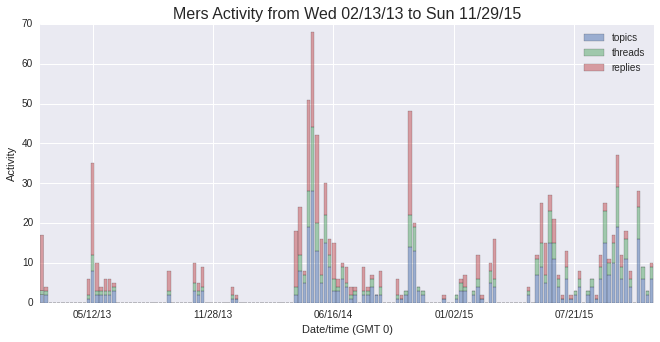

<module 'matplotlib.pyplot' from '/usr/lib/pymodules/python2.7/matplotlib/pyplot.pyc'>

In [19]:
hoursInMonth = 730
hoursInWeek = 168

coronaTimes = getTimes(fullTree)
lastYearCorona = trimRange(coronaTimes,'December 1st, 2012','December 1st, 2015')
timePlot(coronaTimes,'Mers Activity',divFactor=hoursInWeek,overlay=False)

###Pulling country list

In [20]:
countries = [item.split(' - ')[0].lower() for item in fullTree.keys() if ' - coronavirus' in item]
countries = sorted(countries)
addAcronyms = lambda x: [item.strip() for item in x.replace(')','').split('(')]
countries = [addAcronyms(item) for item in countries]
    
print countries

[['algeria'], ['austria'], ['bangladesh'], ['china'], ['egypt'], ['france'], ['germany'], ['greece'], ['indonesia'], ['iran'], ['jordan'], ['kuwait'], ['lebanon'], ['malaysia'], ['netherlands'], ['oman'], ['philippines'], ['qatar'], ['saudi arabia'], ['south korea'], ['tunisia'], ['turkey'], ['united kingdom', 'uk'], ['united states'], ['yemen']]


###Organizing manually curated topic lists

In [21]:
#Lists manually curated from cases 1-500
symptomList = ['anemia', 'asthma', 'asymptomatic', 'bronchitis', 'critical condition', 'diarrhea', 'fever', 'flu symptoms', 'hypertension', 'inflammation of the urethra', 'influenza-like illness', 'kidney failure', 'lung problems', 'pneumonia', 'pneumonia,', 'respiratory', 'shortness of breath', 'vomit']
interventionList = ['artificial respiratory system', 'icu', 'intensive care', 'respirator', 'ventillate']
comorbidityList = ['asthma', 'cancer', 'chronic disease', 'chronic heart', 'chronic illness', 'chronic lung', 'coexisting medical condition', 'coexisting medical conditions', 'comorbidity', 'diabetes', 'health problems', 'heart disease', 'high blood pressure', 'liver failure', ['multiple comorbidities','comorbidities'], 'nephritic syndrome', 'underlying']
exposureList = ['brother of', 'camel', 'camel market', 'camel milk', 'case', 'cluster', 'co-worker', 'contact of previous', 'contact with camels', 'doctor', 'family contact', 'father of', 'health care worker', 'husband of', 'other animal', 'owns a farm', 'roomate of', 'sister of', 'son of', 'travel to UAE', 'travel to saudi arabia', 'wife of']

In [22]:
epiCategories = {'country':countries}
epiLists = {'symptoms':symptomList,
        'interventions':interventionList,
        'comorbidities':comorbidityList,
        'exposures':exposureList}

###Parsing the case list to a dataframe
https://flutrackers.com/forum/forum/novel-coronavirus-ncov-mers-2012-2014/146270-2012-2015-case-list-of-moh-who-novel-coronavirus-mers-ncov-announced-cases

In [23]:
listLink = 'https://flutrackers.com/forum/forum/novel-coronavirus-ncov-mers-2012-2014/146270-2012-2015-case-list-of-moh-who-novel-coronavirus-mers-ncov-announced-cases'
listLines = getRows(listLink,startString='2012 cases',endString='total case count',pad=3,v=False)
caseLines = getLinesContent(listLines,'target="_blank">#')
caseDf = caseLinesToDf(caseLines,categories=epiCategories,lists=epiLists)
print "%s total entries read" % len(caseDf)

1495 total entries read


In [24]:
caseDf[0:15]

,country,gender,age,died,tSymptomatic,tHospital,tDeath,symptoms,comorbidities,exposures,interventions,caseIndex,links
0,jordan,female,45,False,NaN,NaN,NaN,none,none,health care worker,none,1,http://www.flutrackers.com/forum/showpost.php?...
1,jordan,male,25,False,NaN,NaN,NaN,none,none,none,none,2,http://www.flutrackers.com/forum/showpost.php?...
2,saudi arabia,male,60,False,NaN,NaN,NaN,none,none,none,none,3,http://www.who.int/csr/don/2012_09_25/en/
3,qatar,male,49,False,NaN,NaN,NaN,none,none,none,none,4,http://www.who.int/csr/don/2012_09_23/en/
4,saudi arabia,male,NaN,False,NaN,NaN,NaN,none,none,none,none,5,http://www.promedmail.org/direct.php?id=201211...
5,qatar,male,45,False,NaN,NaN,NaN,none,none,none,none,6,http://www.who.int/csr/don/2012_11_23/en/
6,saudi arabia,male,NaN,False,NaN,NaN,NaN,none,none,none,none,7,http://www.promedmail.org/direct.php?id=201211...
7,saudi arabia,male,NaN,False,NaN,NaN,NaN,none,none,none,none,8,http://www.who.int/csr/don/2012_11_23/en/
8,saudi arabia,male,NaN,False,NaN,NaN,NaN,none,none,none,none,9,http://www.who.int/csr/don/2012_11_30/en/
9,saudi arabia,male,60,False,NaN,NaN,NaN,none,none,none,icu,10,http://www.who.int/csr/don/2013_02_11b/en/


#Epidemiology

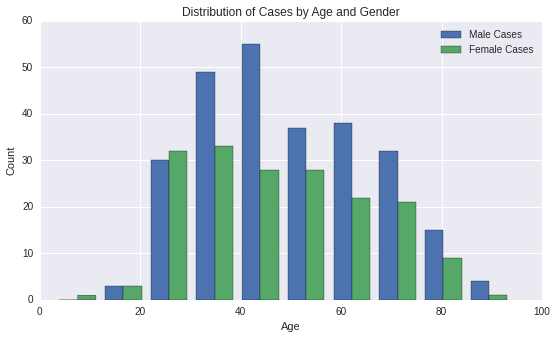

In [25]:
temp = caseDf[pd.notnull(caseDf['age'])]
temp = temp[pd.notnull(temp['gender'])]
maleCases = list(temp[temp['gender'] == 'male']['age'])
femaleCases = list(temp[temp['gender'] == 'female']['age'])

makeHists([maleCases,femaleCases],
          ['Male Cases','Female Cases'],
          "Distribution of Cases by Age and Gender")

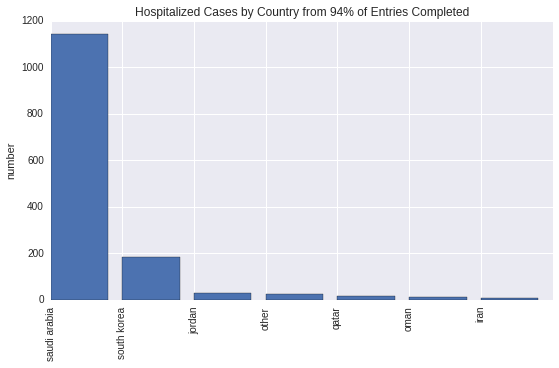

In [26]:
plotCol(list(caseDf['country']),'Hospitalized Cases by Country')

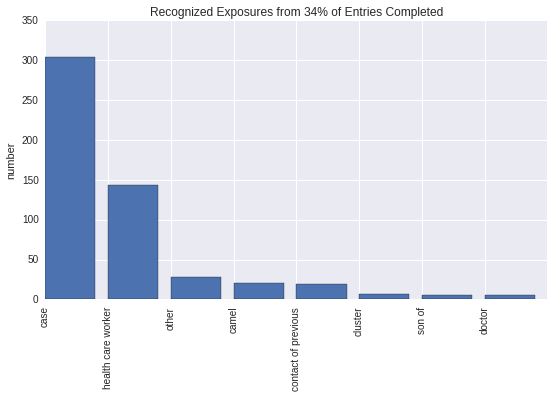

In [27]:
plotCol(list(caseDf['exposures']),'Recognized Exposures',compound=True)

#Clinical symptoms

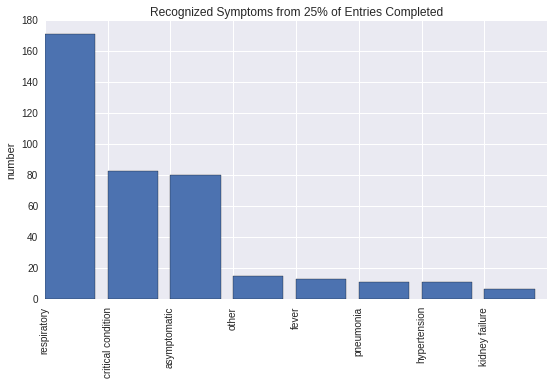

In [28]:
plotCol(list(caseDf['symptoms']),'Recognized Symptoms',compound=True)

#Impact on Society and Individuals:

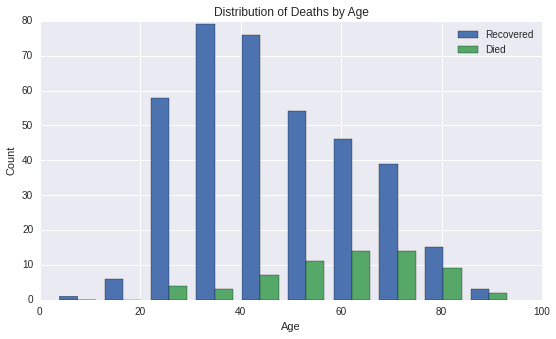

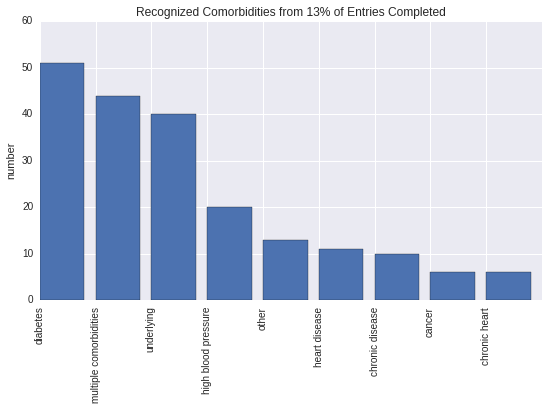

In [29]:
temp = caseDf[pd.notnull(caseDf['age'])]
survivors = list(temp[temp['died'] == False]['age'])
deaths = list(temp[temp['died'] == True]['age'])

makeHists([survivors,deaths],
          ['Recovered','Died'],
          "Distribution of Deaths by Age")

plotCol(list(caseDf['comorbidities']),'Recognized Comorbidities',compound=True)

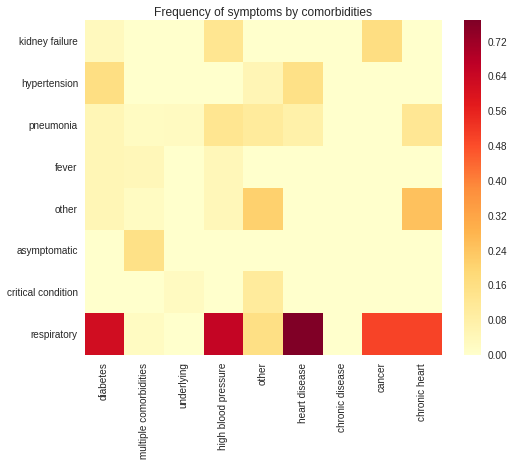

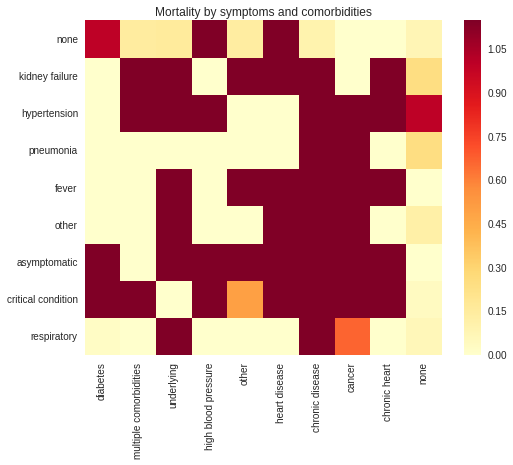

In [36]:
plotMortalityByFeatures(caseDf,'symptoms','comorbidities',compound=True)

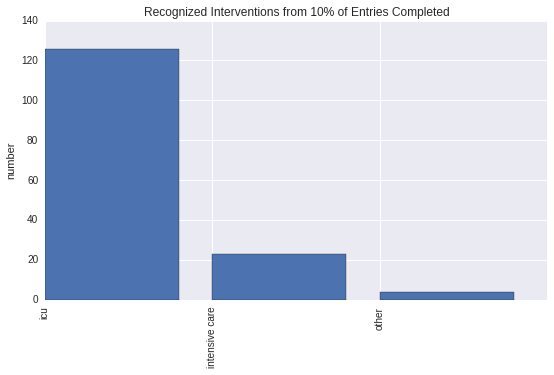

In [31]:
plotCol(list(caseDf['interventions']),'Recognized Interventions',compound=True)

#Works Cited
 - 2012-2015 Case List of MoH/WHO Novel Coronavirus MERS nCoV Announced Cases. (n.d.). Retrieved November 27th, 2015, from https://flutrackers.com/forum/forum/novel-coronavirus-ncov-mers-2012-2014/146270-2012-2015-case-list-of-moh-who-novel-coronavirus-mers-ncov-announced-cases 

WhisperCat will be released at https://github.com/jschlitt84 under the GNU General public license when complete.